In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)
from deepsphere.healpy_layers import HealpySmoothing

os.environ["OMP_NUM_THREADS"] = str(len(os.sched_getaffinity(0)))
import healpy as hp

from msfm.utils import files, redshift, clustering, scales, input_output
from msfm.fiducial_pipeline import FiducialPipeline

# setup

In [3]:
conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias.yaml"
conf = files.load_config(conf)
hp_datapath = "/global/u2/a/athomsen/multiprobe-simulation-forward-model/data/healpy_data"

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]
l_min_global = 20
l_max_global = 1535
data_vec_pix, patches_pix_dict, corresponding_pix_dict, _ = files.load_pixel_file(conf)

# fiducial values
Aia = conf["analysis"]["fiducial"]["Aia"]
n_Aia = conf["analysis"]["fiducial"]["n_Aia"]

bg = conf["analysis"]["fiducial"]["bg"]
n_bg = conf["analysis"]["fiducial"]["n_bg"]

z0 = conf["analysis"]["modelling"]["z0"]

# metacal
metacal_bins = conf["survey"]["metacal"]["z_bins"]
n_z_metacal = len(metacal_bins)
tomo_z_metacal, tomo_nz_metacal = files.load_redshift_distributions("metacal", conf)
tomo_Aia = redshift.get_tomo_amplitudes(Aia, n_Aia, tomo_z_metacal, tomo_nz_metacal, z0)

# maglim
maglim_bins = conf["survey"]["metacal"]["z_bins"]
n_z_maglim = len(maglim_bins)
tomo_z_maglim, tomo_nz_maglim = files.load_redshift_distributions("maglim", conf)
tomo_n_gal_maglim = np.array(conf["survey"]["maglim"]["n_gal"]) * hp.nside2pixarea(n_side, degrees=True)
tomo_bg = redshift.get_tomo_amplitudes(bg, n_bg, tomo_z_maglim, tomo_nz_maglim, z0)

n_z = n_z_metacal + n_z_maglim

24-10-07 23:18:22     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 


In [30]:
dlss_conf = "/global/homes/a/athomsen/y3-deep-lss/configs/v11/clustering/smoothing_fwhm/dlss_16mpc.yaml"
dlss_conf = input_output.read_yaml(dlss_conf)

# scales
theta_fwhms = dlss_conf["scale_cuts"]["lensing"]["theta_fwhm"] + dlss_conf["scale_cuts"]["clustering"]["theta_fwhm"]
l_maxs_naive = list(scales.angle_to_ell(np.array(theta_fwhms), arcmin=True).astype(int))
sigmas = dlss_conf["scale_cuts"]["lensing"]["white_noise_sigma"] + dlss_conf["scale_cuts"]["clustering"]["white_noise_sigma"] 

# TODO shouldn't be hardcoded
l_maxs = [556, 814, 1097, 1307] + [267, 390, 509, 610]

In [31]:
i_ex = 0
i_z = 7
theta_fwhm = theta_fwhms[i_z]
sigma = sigmas[i_z]
l_max = l_maxs[i_z]

rng = np.random.default_rng(12345)

# load the full sky maps

In [6]:
%%time
# fidu_dir = "/global/cfs/cdirs/des/cosmogrid/v11desy3/fiducial/cosmo_fiducial"
# fidu_dir = "/pscratch/sd/a/athomsen/v11desy3/fiducial/cosmo_fiducial"
fidu_dir = "/global/cfs/cdirs/des/cosmogrid/v11desy3/CosmoGrid/v11desy3/fiducial/cosmo_fiducial"

# n_examples = 10
n_examples = 2

wl = []
gc = []
for i in tqdm(range(n_examples)):
    with h5py.File(os.path.join(fidu_dir, f"perm_{i:04d}", "projected_probes_maps_v11dmb.h5"), "r") as f:
        kg = []
        ia = []
        for z_bin in metacal_bins:
            kg.append(hp.ud_grade(f[f"map/kg/{z_bin}"], n_side))
            ia.append(hp.ud_grade(f[f"map/ia/{z_bin}"], n_side))
        kg = np.stack(kg, axis=-1)
        ia = np.stack(ia, axis=-1)
        
        wl.append(kg + tomo_Aia * ia)

        dg = []
        for z_bin in maglim_bins:
            dg.append(hp.ud_grade(f[f"map/dg/{z_bin}"], n_side))
        dg = np.stack(dg, axis=-1)
        
        gc.append(clustering.galaxy_density_to_count(tomo_n_gal_maglim, (dg - np.mean(dg))/np.mean(dg), tomo_bg, nest=False))

wl = np.stack(wl, axis=0)
gc = np.stack(gc, axis=0)

fidu_maps = np.concatenate([wl, gc], axis=-1)

print(fidu_maps.shape)

100%|██████████| 2/2 [02:02<00:00, 61.42s/it]


(2, 3145728, 8)
CPU times: user 1min 40s, sys: 22.1 s, total: 2min 2s
Wall time: 2min 3s


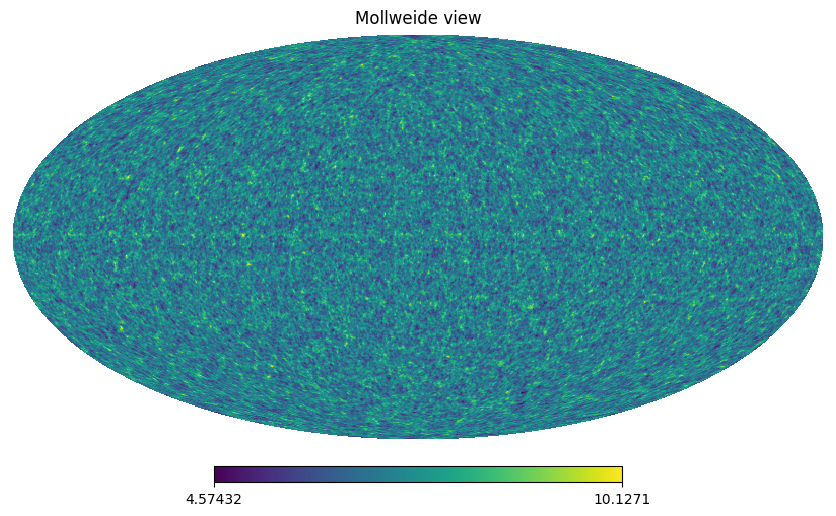

In [45]:
sky_raw = fidu_maps[i_ex, :, i_z]
sky_raw_cls = hp.anafast(sky_raw)

sky_smooth, sky_smooth_alms = scales.map_to_smoothed_map(
    sky_raw, n_side=n_side, theta_fwhm=theta_fwhm, hard_cut=False, conf=conf
)
sky_smooth_cls = hp.alm2cl(sky_smooth_alms)

sky_noisy = sky_smooth + rng.normal(scale=sigma, size=n_pix)
sky_noisy_cls = hp.anafast(sky_noisy)

hp.mollview(sky_noisy)

# masked sky

In [24]:
mask = patches_pix_dict["metacal"][0][0]
anti_mask = np.setdiff1d(np.arange(n_pix), mask)
f_sky = n_pix/(n_pix - len(anti_mask))

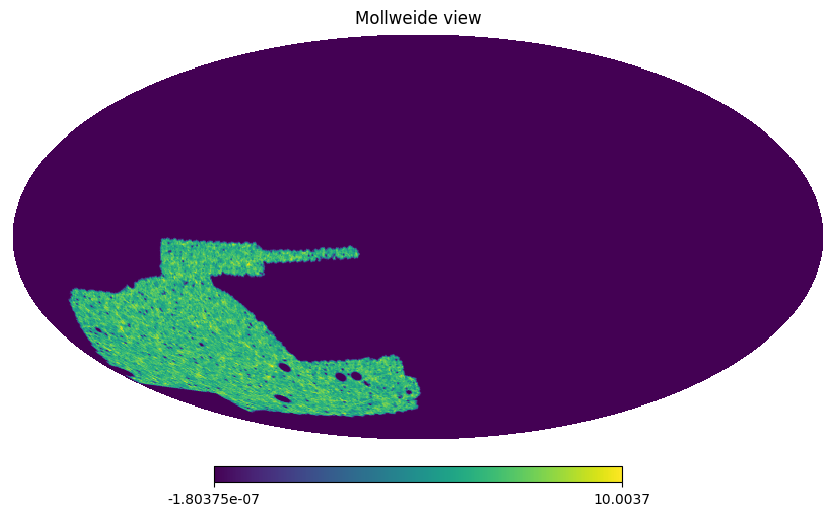

In [53]:
patch_raw = sky_raw.copy()
patch_raw[anti_mask] = hp.UNSEEN
patch_raw_cls = hp.anafast(patch_raw)

patch_smooth, patch_smooth_alms = scales.map_to_smoothed_map(
    patch_raw, n_side=n_side, theta_fwhm=theta_fwhm, hard_cut=False, conf=conf,
)
patch_smooth_cls = hp.alm2cl(patch_smooth_alms)

patch_noisy = patch_smooth.copy()
patch_noisy[mask] += rng.normal(scale=sigma, size=len(mask))
patch_noisy_cls = hp.anafast(patch_noisy)

patch_noisy_fsky = patch_smooth.copy()
patch_noisy_fsky[mask] += np.sqrt(f_sky) * rng.normal(scale=sigma, size=len(mask))
patch_noisy_fsky_cls = hp.anafast(patch_noisy_fsky)

hp.mollview(patch_noisy)

# comparison

[Text(0.5, 0, '$\\ell$'), Text(0, 0.5, '$C_\\ell$'), None, (1e-09, 0.001)]

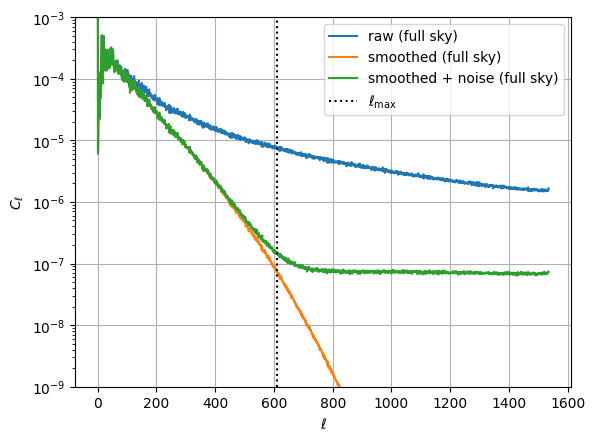

In [46]:
fig, ax = plt.subplots()

ax.plot(sky_raw_cls, label="raw (full sky)")
ax.plot(sky_smooth_cls, label="smoothed (full sky)")
ax.plot(sky_noisy_cls, label="smoothed + noise (full sky)")

ax.axvline(l_max, label=r"$\ell_{\mathrm{max}}$", color="k", linestyle=":")

ax.grid(True)
ax.legend()
ax.set(xlabel=r"$\ell$", ylabel=r"$C_\ell$", yscale="log", ylim=(1e-9, 1e-3))

[Text(0.5, 0, '$\\ell$'), Text(0, 0.5, '$C_\\ell$'), None, (1e-09, 0.001)]

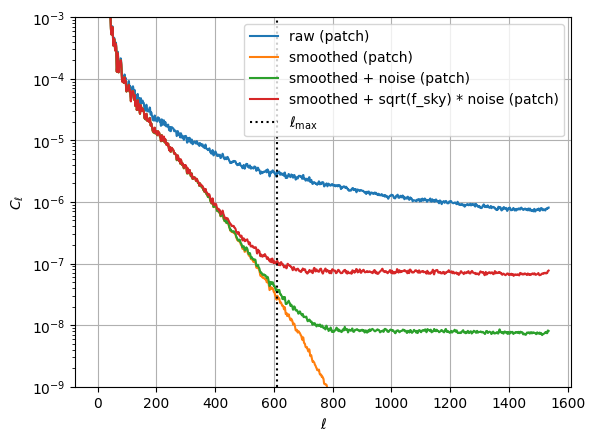

In [54]:
fig, ax = plt.subplots()

ax.plot(patch_raw_cls, label="raw (patch)")
ax.plot(patch_smooth_cls, label="smoothed (patch)")
ax.plot(patch_noisy_cls, label="smoothed + noise (patch)")
ax.plot(patch_noisy_fsky_cls, label="smoothed + sqrt(f_sky) * noise (patch)")

ax.axvline(l_max, label=r"$\ell_{\mathrm{max}}$", color="k", linestyle=":")

ax.grid(True)
ax.legend()
ax.set(xlabel=r"$\ell$", ylabel=r"$C_\ell$", yscale="log", ylim=(1e-9, 1e-3))

[Text(0.5, 0, '$\\ell$'), Text(0, 0.5, '$C_\\ell$'), None, (1e-09, 0.001)]

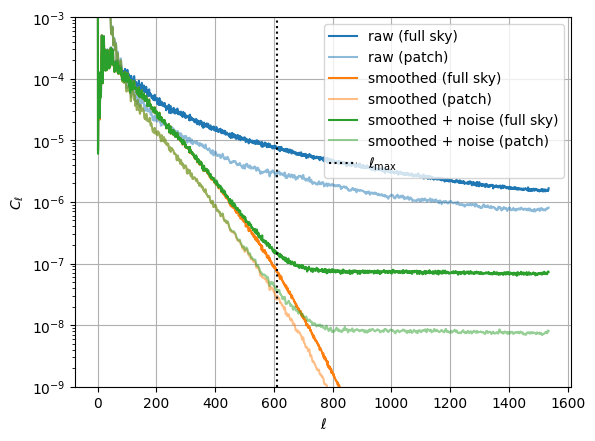

In [64]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
fig, ax = plt.subplots()

ax.plot(sky_raw_cls, label="raw (full sky)", color=colors[0])
ax.plot(patch_raw_cls, label="raw (patch)", color=colors[0], alpha=0.5)

ax.plot(sky_smooth_cls, label="smoothed (full sky)", color=colors[1])
ax.plot(patch_smooth_cls, label="smoothed (patch)", color=colors[1], alpha=0.5)

ax.plot(sky_noisy_cls, label="smoothed + noise (full sky)", color=colors[2])
ax.plot(patch_noisy_cls, label="smoothed + noise (patch)", color=colors[2], alpha=0.5)
# ax.plot(patch_noisy_fsky_cls, label="smoothed + sqrt(f_sky) * noise (patch)", color=colors[3], alpha=0.5)

ax.axvline(l_max, label=r"$\ell_{\mathrm{max}}$", color="k", linestyle=":")

ax.grid(True)
ax.legend()
ax.set(xlabel=r"$\ell$", ylabel=r"$C_\ell$", yscale="log", ylim=(1e-9, 1e-3))

[Text(0.5, 0, '$\\ell$'), Text(0, 0.5, '$C_\\ell$'), None, (0.1, 100.0)]

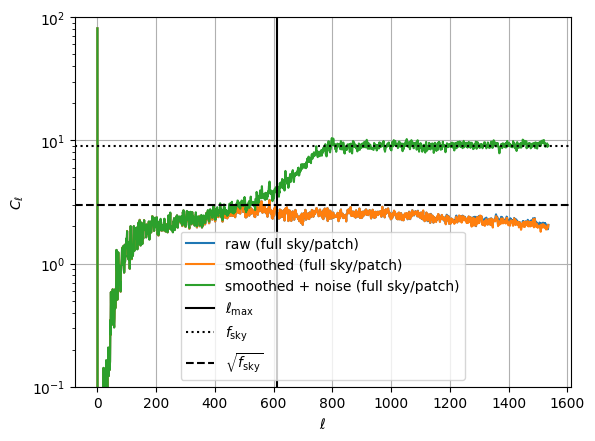

In [74]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
fig, ax = plt.subplots()

ax.plot(sky_raw_cls/patch_raw_cls, label="raw (full sky/patch)", color=colors[0])

ax.plot(sky_smooth_cls/patch_smooth_cls, label="smoothed (full sky/patch)", color=colors[1])

ax.plot(sky_noisy_cls/patch_noisy_cls, label="smoothed + noise (full sky/patch)", color=colors[2])

ax.axvline(l_max, label=r"$\ell_{\mathrm{max}}$", color="k", linestyle="-")
ax.axhline(f_sky, label=r"$f_{\mathrm{sky}}$", color="k", linestyle=":")
ax.axhline(np.sqrt(f_sky), label=r"$\sqrt{f_{\mathrm{sky}}}$", color="k", linestyle="--")

ax.grid(True)
ax.legend()
ax.set(xlabel=r"$\ell$", ylabel=r"$C_\ell$", yscale="log", ylim=(1e-1, 1e2))